In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [28]:
df = pd.read_csv("cleaned_US_Accidents.csv", index_col=0)
df = df.drop('State', axis=1)

In [30]:
clean_df = pd.get_dummies(df, columns=["Wind_Direction", "Weather_Condition"])

In [31]:
high_risk = clean_df[clean_df['Severity'] >= 3]

In [32]:
#Look at the most severe plots

X = high_risk.drop('Severity', axis=1)
y = high_risk['Severity']

In [33]:
#split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#train the model
rfc = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)
rfc.fit(X_train, y_train)

print("OOB score:", rfc.oob_score_)

OOB score: 0.8586076061060619


In [34]:
#get the feature importances
importance = rfc.feature_importances_
feat_importance = pd.Series(importance, index=X.columns).sort_values(ascending=False)

print("Feature Importance:")
print(feat_importance)

Feature Importance:
Pressure(in)                                             0.222061
Humidity(%)                                              0.181681
Temperature(F)                                           0.163500
Wind_Chill(F)                                            0.104471
Wind_Speed(mph)                                          0.100170
                                                           ...   
Weather_Condition_Heavy Freezing Rain                    0.000000
Weather_Condition_Light Sleet / Windy                    0.000000
Weather_Condition_Heavy Freezing Drizzle                 0.000000
Weather_Condition_Heavy Thunderstorms with Small Hail    0.000000
Weather_Condition_Light Snow Shower                      0.000000
Length: 166, dtype: float64


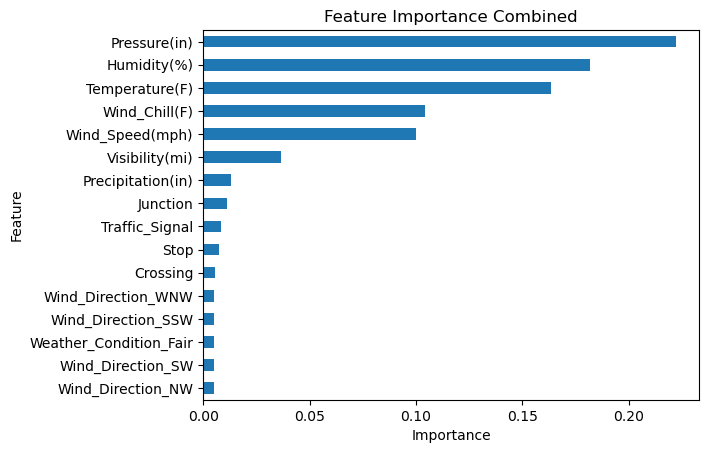

In [42]:
k = len(feat_importance) // 10
indices = np.argsort(feat_importance)[-k:]
new_feat_import = feat_importance.iloc[indices]

new_feat_import.plot(kind='barh')
plt.title("Feature Importance of Weather and Infrastructure")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [43]:
print("Train accuracy:", rfc.score(X_train, y_train))
print("Test accuracy:", rfc.score(X_test, y_test))

Train accuracy: 0.9953880996499898
Test accuracy: 0.8579924469699644
